In [1]:
pip install opencv-python

In [2]:
import glob
import cv2
import os

import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import tensorflow.keras.optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16, EfficientNetB0
print(tf.__version__)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import manifold

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
from matplotlib import offsetbox
import matplotlib.colors as colors
import matplotlib.cm as cmx

2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# open csv file (note - target and filename only references one single eye)

df = pd.read_csv("/content/drive/MyDrive/EfficientNet/clothing-dataset-master/clothing-dataset-master/images.csv")
df.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [8]:
df = df[df['label'].isin(['Shoes', 'Dress', 'Longsleeve', 'T-Shirt', 'Hat'])]

data, labels = [], []
for index, row in df.iterrows():
    image_path = f'/content/drive/MyDrive/EfficientNet/clothing-dataset-master/clothing-dataset-master/images/{row["image"]}.jpg'
    label = row['label']
    try:
        image = tf.keras.preprocessing.image.load_img(image_path, color_mode='rgb', target_size= (224, 224))
        image = np.array(image)
        data.append(image)
        labels.append(label)
    except Exception:
        print(f'Failed to load {image_path}')
        
print(f'Loaded {len(data)} images') 

label_set = list(set(df['label']))
print(f'Image classes {label_set}')
print(df[['label', 'image']].groupby(['label']).agg(['count']))


#
# Data pre-processing
#
x = np.array(data)
y = np.array(labels)

# EfficientNet models expect their inputs to be float tensors 
# of pixels with values in the [0-255] range.
x = x.astype('float32') 

mlb = MultiLabelBinarizer()
mlb.fit([label_set])
y = mlb.transform(np.atleast_2d(y).T)
print(f'Label mapper classes {mlb.classes_}')


#
# Data split
#
# x - n_samples X height X width X channels
# y - n_samples X onehot_labels
train_test_ratio = 0.75
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_test_ratio)
print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')
print(f'y_train: {y_train.shape}, y_test: {y_test.shape}')


Loaded 2669 images
Image classes ['T-Shirt', 'Hat', 'Dress', 'Longsleeve', 'Shoes']
           image
           count
label           
Dress        357
Hat          171
Longsleeve   699
Shoes        431
T-Shirt     1011
Label mapper classes ['Dress' 'Hat' 'Longsleeve' 'Shoes' 'T-Shirt']
x_train: (2001, 224, 224, 3), x_test: (668, 224, 224, 3)
y_train: (2001, 5), y_test: (668, 5)


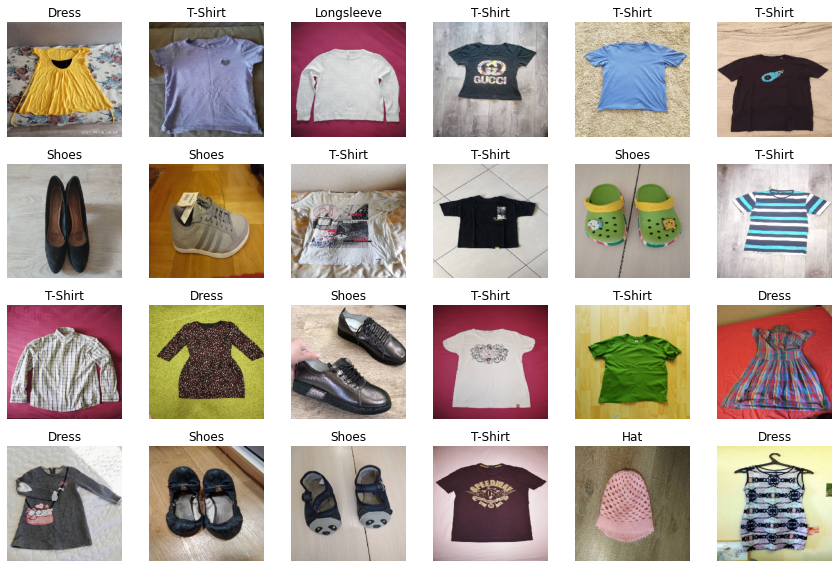

In [9]:
#
# Visualize a data sample 
#
def decode_labels(y, mlb):
    labels = np.array(mlb.inverse_transform(np.atleast_2d(y)))[:, 0]
    return labels

n_col, n_row = 6, 4
offset = 200
f, ax = plt.subplots(n_row, n_col, figsize=(12, 8))
for i in range(n_row):
    for j in range(n_col):
        idx = offset + n_col*i + j
        ax[i, j].imshow(x_train[idx]/255)
        ax[i, j].set_axis_off()
        ax[i, j].set_title(decode_labels(y_train[idx], mlb)[0])
plt.tight_layout()

In [10]:
#
# Fine-tune a pretrained EfficientNet model   
#
model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in model.layers:
    layer.trainable = False
    
mapper = model.output
mapper = Flatten()(mapper) 
mapper = Dense(32, activation='relu', name='embeddigns')(mapper)
mapper = Dense(y_train.shape[1], activation='softmax')(mapper)
transfer_model = Model(inputs=model.input, outputs=mapper)

learning_rate= 0.001
transfer_model.compile(loss="categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics = ["accuracy"])
history = transfer_model.fit(x_train, y_train, batch_size = 4, epochs=4, validation_data=(x_test, y_test))

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/4
501/501 [==============================] - 155s 298ms/step - loss: 0.6267 - accuracy: 0.8561 - val_loss: 0.3817 - val_accuracy: 0.8683
Epoch 2/4
501/501 [==============================] - 134s 268ms/step - loss: 0.2591 - accuracy: 0.9215 - val_loss: 0.3247 - val_accuracy: 0.8997
Epoch 3/4
501/501 [==============================] - 134s 268ms/step - loss: 0.1669 - accuracy: 0.9480 - val_loss: 0.3030 - val_accuracy: 0.9102
Epoch 4/4
501/501 [==============================] - 134s 267ms/step - loss: 0.1515 - accuracy: 0.9620 - val_loss: 0.4842 - val_accuracy: 0.9102


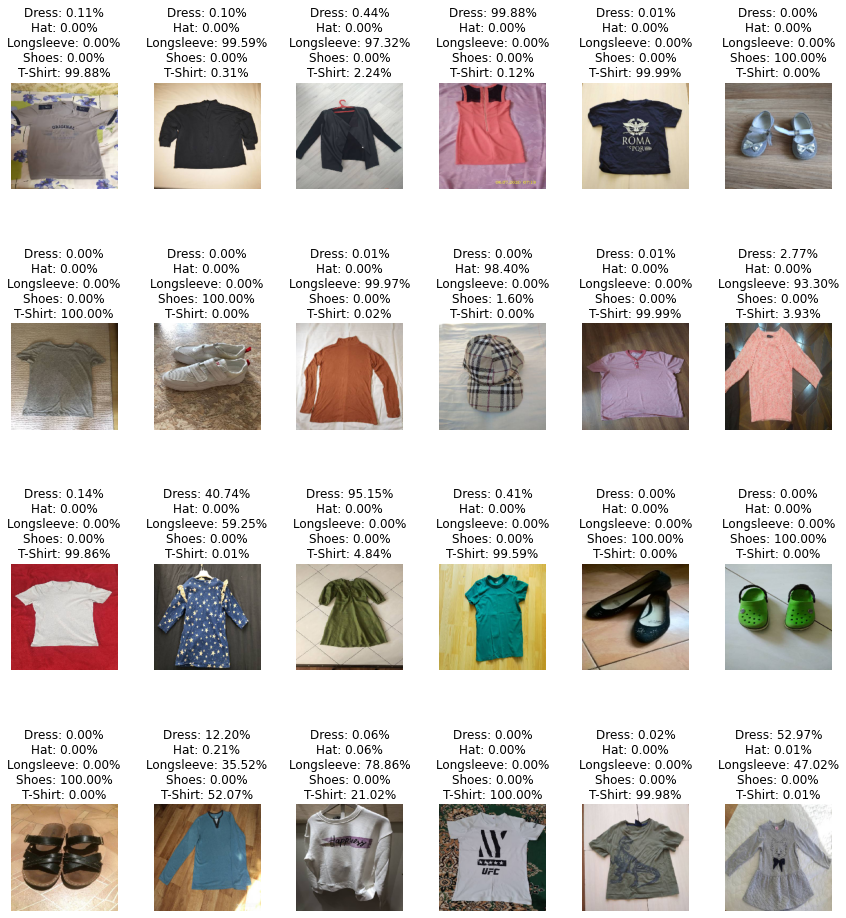

In [11]:
#
# Visualize image class probabilities 
#
def decode_label_prob(y, classes):
    labels = []
    for i ,c in enumerate(classes):
        labels.append(f'{c}: {y[i]:.2%}')
    return labels

n_col, n_row = 6, 4
f, ax = plt.subplots(n_row, n_col, figsize=(12, 14))
for i in range(n_row):
    for j in range(n_col):
        idx = n_col*i + j
        class_probs = transfer_model.predict(x_test[idx:idx+1])[0]
        ax[i, j].imshow(x_test[idx]/255)
        ax[i, j].set_axis_off()
        ax[i, j].set_title('\n'.join(decode_label_prob(class_probs, mlb.classes_)))
        
plt.tight_layout()

In [12]:
#
# Compute the embeddings for visualization
#
n_samples = 1000
embedding_outputs = transfer_model.get_layer('embeddigns').output
embedding_model = Model([transfer_model.input], embedding_outputs)

images = x_test[0:n_samples]
image_embeddings = embedding_model.predict(images)
image_labels = decode_labels(y_test[0:n_samples], mlb)
print(image_embeddings.shape)

(668, 32)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


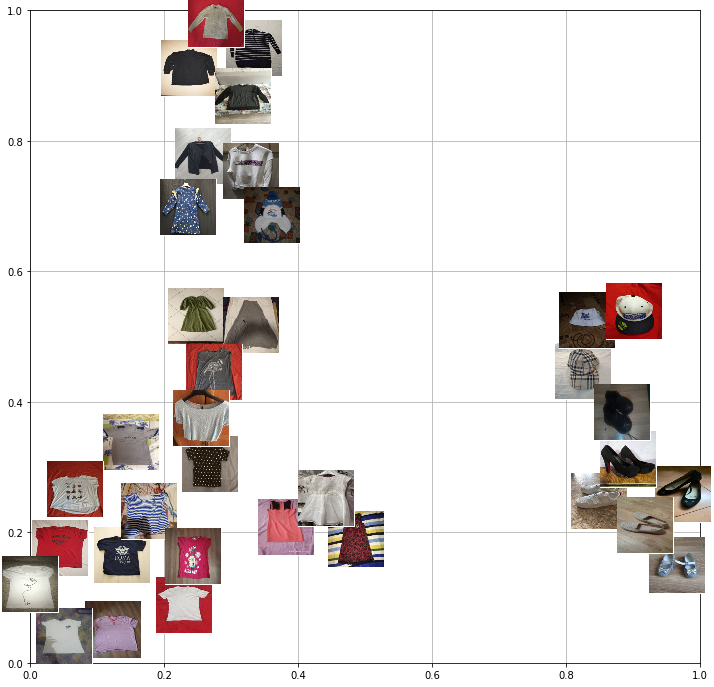

In [13]:
#
# Visualize the 2D-projection of the embedding space with example images (thumbnails)
#
def embedding_plot(X, y_labels, images, mode = 'points', thumbnail_sparsity = 0.005, thumbnail_size = 0.25):
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    X = (X - x_min) / (x_max - x_min)
    fig, ax = plt.subplots(1, figsize=(12, 12))
    
    if mode == 'points':
        uniq = list(set(y_labels))
        z = range(1, len(uniq))
        hot = plt.get_cmap('viridis')
        cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)
    
        for i in range(len(uniq)):
            indx = np.argwhere(y_labels == uniq[i]).T
            ax.scatter(X[indx, 0], X[indx, 1], s=30, marker='o', 
                    color=scalarMap.to_rgba(i), label=uniq[i], alpha=0.5) 
        plt.legend(loc='upper left')

    if mode == 'thumbnails':
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            if np.min(np.sum((X[i] - shown_images) ** 2, axis=1)) < thumbnail_sparsity: continue
            shown_images = np.r_[shown_images, [X[i]]]
            thumbnail = offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r, zoom=thumbnail_size)
            ax.add_artist(offsetbox.AnnotationBbox(thumbnail, X[i], bboxprops = dict(edgecolor='white'), pad=0.0))

    plt.grid(True)
    
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=20, random_state=0)
X_tsne = tsne.fit_transform(image_embeddings)
embedding_plot(X_tsne, y_labels=image_labels, images=images/255, mode = 'thumbnails')

In [14]:
inputs = tensorflow.keras.layers.Input((10, 10, 1))
conv = tensorflow.keras.layers.Conv2DTranspose(1, kernel_size=(2, 2), strides=(2,2))(inputs)
model = Model(inputs=inputs, outputs=conv)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 10, 1)]       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 20, 1)        5         
 nspose)                                                         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
